# FedProx Optimizers


In [1]:
import openfl.native as fx
from openfl.federated import FederatedModel, FederatedDataSet

## Load Dataset and Transfer 
### Define Torch Dataloader

In [2]:
from openfl.federated import FederatedModel,FederatedDataSet

from openfl.utilities.data_splitters import DirichletNumPyDataSplitter
from openfl.utilities.data_splitters import EqualNumPyDataSplitter
from openfl.utilities.data_splitters import LogNormalNumPyDataSplitter
from openfl.utilities.data_splitters import RandomNumPyDataSplitter

import DataSplitterMethods
data_splitter = DataSplitterMethods.SplitFunctionGenerator("1-Class-per-collab-split")

import torch
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Replace here with path of your folder. 
dataset = torchvision.datasets.ImageFolder(root='/home/shivam/Documents/Gatech_Coursework/Semester 2/AIC/Final Project/content/gaussian_filtered_images/gaussian_filtered_images', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

### Display data into train and valid sets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

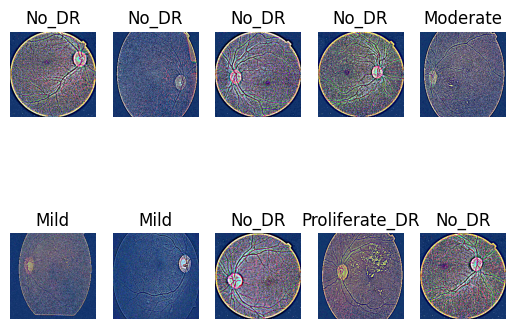

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def index_to_class_name(index, dataset):
    return dataset.classes[index]

len_images = 10
images, labels = next(iter(dataloader))
sample_indices = np.random.choice(len(images), len_images, replace=False)
sample_images = images[sample_indices]
sample_labels = labels[sample_indices]

for i, image in enumerate(sample_images):
    class_name = index_to_class_name(sample_labels[i], dataset)
    plt.subplot(2, 5, i+1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(class_name)
    plt.axis('off')

plt.show() 

In [4]:
import matplotlib.pyplot as plt
import numpy as np

### Distribute data into train and valid data sets


In [5]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data, labels = next(iter(data_loader))
print("The data shape is {}".format(data.shape))

The data shape is torch.Size([3662, 3, 224, 224])


In [6]:
import torch.nn.functional as F
def split_and_return_train_valid(data, labels, split = 0.2):
  test_indices = np.random.rand(data.shape[0]) < split
  train_indices = ~test_indices
  train_data, test_data = data[train_indices], data[test_indices]
  train_labels, test_labels = labels[train_indices], labels[test_indices]
  train_labels, test_labels = F.one_hot(train_labels), F.one_hot(test_labels)
  return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = split_and_return_train_valid(data, labels) 
print("Train Data Length is {}".format(len(train_data)))
print("Test Data Length is {}".format(len(test_data)))

Train Data Length is 2901
Test Data Length is 761


In [7]:
from openfl.federated import FederatedModel,FederatedDataSet
batch_size = 16
num_classes = 5
fl_data = FederatedDataSet(train_data, train_labels, test_data, test_labels, 
                           batch_size = batch_size , num_classes = num_classes, train_splitter = data_splitter)

###  Define Model - Pretrained Model
We can use a pretrained model like Inception or VGG Net to perform classification. These have already been pretrained on large-scale image data and we need to train only some final linear layers.

In [8]:
from openfl.utilities.optimizers.torch import FedProxOptimizer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


class Net(nn.Module):
    def __init__(self, num_classes=5):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.inception = models.googlenet(pretrained=True)
        
        for param in self.inception.parameters():
            param.requires_grad = False
            
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return F.log_softmax(x, dim=1)
    
    def train_epoch(self, batch_generator):
        from openfl.federated.task import PyTorchTaskRunner
        self.optimizer.set_old_weights([p for p in self.parameters()])
        return PyTorchTaskRunner.train_epoch(self, batch_generator)

    
optimizer = lambda x: FedProxOptimizer(x, lr=1e-3, mu=0.1)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(Net())

## Earlier Parameters: 51386181

/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shivam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


5125

In [10]:
net = Net()
net(data[3:8]).shape

torch.Size([5, 5])

In [11]:
fl_model = FederatedModel(build_model=Net, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

tried to remove tensor: __opt_state_needed not present in the tensor dict


### Define OpenFlow Plan

In [12]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

/home/shivam/Documents/Gatech_Coursework/Semester 2/AIC/Final Project/git/AIC_Project_Final_Notebooks/OpenFl/DataSplitterMethods.py:206: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_matrix = np.array([np.array([data[idx] for idx in idx_list]) for idx_list in final_idx])


[array([0]), array([1]), array([2]), array([3]), array([4])]


tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict
tried to remove tensor: __opt_state_needed not present in the tensor dict


In [13]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

Creating Workspace Directories
Creating Workspace Templates
Defaulting to user installation because normal site-packages is not writeable

New workspace directory structure:
workspace
├── envoy_config.yaml
├── cert
├── test_output
├── agg_to_col_3_signed_cert.zip
├── spam_metric.log
├── agg_to_col_1_signed_cert.zip
├── agg_to_col_4_signed_cert.zip
├── shard_descriptor.py
├── save
│   ├── torch_cnn_mnist_init.pbuf
│   ├── keras_cnn_mnist_init.pbuf
│   ├── torch_cnn_mnist_last.pbuf
│   └── torch_cnn_mnist_best.pbuf
├── logs
│   └── cnn_mnist
│       ├── events.out.tfevents.1681513600.Roger.50728.0
│       ├── events.out.tfevents.1681315750.Roger.48608.0
│       ├── events.out.tfevents.1681602412.Roger.21909.0
│       ├── events.out.tfevents.1681536248.Roger.66960.0
│       ├── events.out.tfevents.1681431847.Roger.17954.0
│       ├── events.out.tfevents.1681593468.Roger.13993.0
│       ├── events.out.tfevents.1681434736.Roger.21857.0
│       ├── events.out.tfevents.1681589220.Roger.7572.0

│       ├── events.out.tfevents.1681599867.Roger.19581.0
│       ├── events.out.tfevents.1681512387.Roger.43871.0
│       ├── events.out.tfevents.1681519569.Roger.59873.0
│       ├── events.out.tfevents.1681269401.Roger.8557.0
│       ├── events.out.tfevents.1681601163.Roger.20946.0
│       ├── events.out.tfevents.1681530898.Roger.63326.0
│       ├── events.out.tfevents.1681442737.Roger.16494.0
│       ├── events.out.tfevents.1681500355.Roger.36072.0
│       ├── events.out.tfevents.1681504902.Roger.43395.0
│       ├── events.out.tfevents.1681433866.Roger.20887.0
│       ├── events.out.tfevents.1681603030.Roger.22841.0
│       ├── events.out.tfevents.1681518873.Roger.58996.0
│       ├── events.out.tfevents.1681433027.Roger.19981.0
│       ├── events.out.tfevents.1681269659.Roger.9184.0
│       ├── events.out.tfevents.1681514439.Roger.43369.0
│       ├── events.out.tfevents.1681270907.Roger.12430.0
│       ├── events.out.tfevents.1681515196.Roger.52877.0
│       ├── events.out.tfevents.1

In [ ]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={"aggregator.settings.rounds_to_train": 20})

[17:38:52] INFO     Updating aggregator.settings.rounds_to_train to 20...                                                                          ]8;id=784158;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=351818;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#102\102]8;;\

           INFO     FL-Plan hash is 164df001446fef577a3b2260bf97e83d497b8dbb4f803517902d39a10a643455d3c3e3e1532b03055d7385aed6ebf7ba                 ]8;id=467287;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=514241;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#235\235]8;;\

           INFO     Building 🡆 Object NoCompressionPipeline from openfl.pipelines Module.                                                            ]8;id=814767;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=195062;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Creating Initial Weights File    🠆 save/torch_cnn_mnist_init.pbuf                                                              ]8;id=325771;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=757864;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#277\277]8;;\

           INFO     Starting Experiment...                                                                                                         ]8;id=205606;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py\native.py]8;;\:]8;id=138880;file:///usr/local/lib/python3.8/dist-packages/openfl/native/native.py#281\281]8;;\

           INFO     Building 🡆 Object RandomGroupedAssigner from openfl.component Module.                                                            ]8;id=870478;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=447119;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object CutoffTimeBasedStragglerHandling from openfl.component.straggler_handling_functions Module.                    ]8;id=766989;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=142670;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Importing 🡆 Object write_metric from src.mnist_utils Module.                                                                     ]8;id=90903;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=25924;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#199\199]8;;\

           INFO     Building 🡆 Object Aggregator from openfl.component Module.                                                                       ]8;id=299865;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=305946;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Using custom log metric: <function write_metric at 0x7fe29d0fd310>                                                          ]8;id=949219;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=318460;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#97\97]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=152048;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=780667;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=362750;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=540577;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=891407;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=842106;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=533460;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=245461;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Building 🡆 Object Collaborator from openfl.component Module.                                                                     ]8;id=733150;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py\plan.py]8;;\:]8;id=164961;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/plan/plan.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=151352;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=947166;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 0 for round 0                                                                                ]8;id=110376;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=36854;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=711272;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=423772;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[17:38:53] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=377090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=737566;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:284: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  new_state[k] = pt.from_numpy(tensor_dict.pop(k)).to(device)
/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[17:38:58] METRIC   Round 0, collaborator 0 is sending metric for task aggregated_model_validation: acc     0.137255                         ]8;id=600341;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=843902;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for aggregated_model_validation, round 0                                            ]8;id=920797;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=326594;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.137255                                   ]8;id=662488;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=536104;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=607267;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=554198;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=388588;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=309009;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[17:38:59] METRIC   Round 0, collaborator 0 is sending metric for task train: cross_entropy 0.438860                                         ]8;id=494979;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=308617;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for train, round 0                                                                  ]8;id=239247;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=394218;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.438860                                                   ]8;id=772699;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=965626;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     Using TaskRunner subclassing API                                                                                         ]8;id=949742;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=109929;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 0 is sending metric for task locally_tuned_model_validation: acc  0.137255                         ]8;id=182458;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=884923;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 0 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=417179;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=554813;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.137255                                   ]8;id=367733;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=665152;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 0 for round 0...                                                                                  ]8;id=903264;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=143873;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=395940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=793185;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 1 for round 0                                                                                ]8;id=149961;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=102377;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=220110;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=921384;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

[17:39:00] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=624940;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=241905;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 1 is sending metric for task aggregated_model_validation: acc     0.151316                         ]8;id=863082;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=701437;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for aggregated_model_validation, round 0                                            ]8;id=335871;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=659876;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_agg aggregated_model_validation result acc:      0.151316                                   ]8;id=370162;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=940419;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[17:39:01] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=837204;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=594203;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

           INFO     Run 0 epoch of 0 round                                                                                                      ]8;id=236264;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py\runner_pt.py]8;;\:]8;id=380253;file:///usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py#155\155]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:458: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


[17:39:02] METRIC   Round 0, collaborator 1 is sending metric for task train: cross_entropy 0.415948                                         ]8;id=154279;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=487873;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for train, round 0                                                                  ]8;id=190633;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=422160;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator metric train result cross_entropy:        0.415948                                                   ]8;id=747494;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=302369;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

[17:39:03] INFO     Using TaskRunner subclassing API                                                                                         ]8;id=433738;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=331562;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#253\253]8;;\

/usr/local/lib/python3.8/dist-packages/openfl/federated/task/runner_pt.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data, target = pt.tensor(data).to(self.device), pt.tensor(


           METRIC   Round 0, collaborator 1 is sending metric for task locally_tuned_model_validation: acc  0.322368                         ]8;id=932505;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=268863;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#415\415]8;;\

           INFO     Collaborator 1 is sending task results for locally_tuned_model_validation, round 0                                         ]8;id=995576;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=993293;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#520\520]8;;\

           METRIC   Round 0, collaborator validate_local locally_tuned_model_validation result acc: 0.322368                                   ]8;id=395698;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=951014;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#559\559]8;;\

           INFO     All tasks completed on 1 for round 0...                                                                                  ]8;id=789276;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=836049;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#171\171]8;;\

           INFO     Waiting for tasks...                                                                                                     ]8;id=769090;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=109769;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#178\178]8;;\

           INFO     Sending tasks to collaborator 2 for round 0                                                                                ]8;id=362402;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py\aggregator.py]8;;\:]8;id=749220;file:///usr/local/lib/python3.8/dist-packages/openfl/component/aggregator/aggregator.py#329\329]8;;\

           INFO     Received the following tasks: ['aggregated_model_validation', 'train', 'locally_tuned_model_validation']                 ]8;id=603882;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py\collaborator.py]8;;\:]8;id=513215;file:///usr/local/lib/python3.8/dist-packages/openfl/component/collaborator/collaborator.py#168\168]8;;\

## FedOpt optimizers 
Running the FedOpt Optimizers


In [ ]:
from openfl.utilities.optimizers.torch import FedProxOptimizer

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


class FedOptNet(nn.Module):
    def __init__(self, num_classes=5):
        super(FedOptNet, self).__init__()
        self.num_classes = num_classes
        self.inception = models.googlenet(pretrained=True)
        
        for param in self.inception.parameters():
            param.requires_grad = False
            
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)

    def forward(self, x):
        x = self.inception(x)
        return F.log_softmax(x, dim=1)
    
optimizer = lambda x: optim.Adam(x, lr=1e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.binary_cross_entropy_with_logits(input=output,target=target.float())

In [ ]:
from openfl.interface.interactive_api.experiment import TaskInterface, ModelInterface
from openfl.interface.aggregation_functions import AdagradAdaptiveAggregation

framework_adapter = 'openfl.plugins.frameworks_adapters.pytorch_adapter.FrameworkAdapterPlugin'

TI = TaskInterface()
MI = ModelInterface(model=FedOptNet(),
                    optimizer=optimizer,
                    framework_plugin=framework_adapter)
...

# Creating aggregation function
agg_fn = AdagradAdaptiveAggregation(model_interface=MI,
                                    learning_rate=0.001)

In [ ]:
fl_model = FederatedModel(build_model=FedOptNet, optimizer=optimizer, loss_fn=cross_entropy, data_loader=fl_data)

In [ ]:
NUM_COLLABORATORS = 5
collaborator_list = [str(i) for i in range(NUM_COLLABORATORS)]
experiment_collaborators = {col_name:col_model for col_name, col_model \
                                 in zip(collaborator_list, fl_model.setup(len(collaborator_list)))}

In [ ]:
fx.init('torch_cnn_mnist', col_names=collaborator_list)

In [ ]:
final_fl_model = fx.run_experiment(experiment_collaborators, override_config={
    "aggregator.settings.rounds_to_train": 20, 
    'tasks.train.aggregation_type': agg_fn})